In [2]:
N0 = 5#initial number of training points
num_times = 1
digs = [4,5]

## Extracting two classes from the MNIST dataset, digits 4 and 5

In [3]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
from torch import optim
from torchvision.transforms import Lambda
from torchvision.transforms.functional import convert_image_dtype
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([
        ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        Lambda(lambda x: x.float()),
        Lambda(lambda x: (x.float() - torch.mean(x.float()))/torch.std(x.float()))
    ]), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.Compose([
        ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        Lambda(lambda x: x.float()),
        Lambda(lambda x: (x.float() - torch.mean(x.float()))/torch.std(x.float()))
    ])
)
#finding indices where target is two or three
def get_mask_digit(digits):
    for cnt,i in enumerate(digits):
        if cnt == 0:
            s_train = train_data.targets == i
            s_test = test_data.targets == i
        else:
            s_train += train_data.targets == i
            s_test += test_data.targets == i
    return torch.squeeze(torch.nonzero(s_train)),torch.squeeze(torch.nonzero(s_test))
### select two digits for classification
mask_train, mask_test = get_mask_digit(digs)
test_data = torch.utils.data.Subset(test_data, mask_test)
sum(train_data.targets[mask_train[:N0]] == digs[0]),sum(train_data.targets[mask_train[:N0]] == digs[1])

def set_seed():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(0)
set_seed()

## Visualize datasets

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               ConvertImageDtype()
               Lambda()
               Lambda()
           )


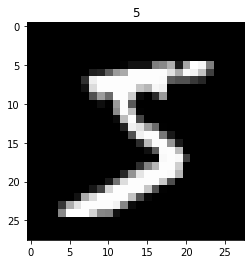

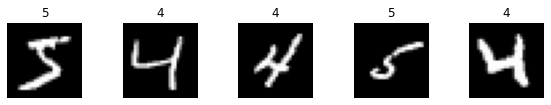

In [4]:
print(train_data)
print(test_data)

plt.imshow(train_data.data[mask_train[0]], cmap='gray')
plt.title('%i' % train_data.targets[mask_train[0]])
plt.show()
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for cnt,i in enumerate(range(1, N0+1)):
    sample_idx = mask_train[:N0][cnt%N0]#torch.randint(len(mask_train[:N0]), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [25]:
# Defining training and testing modules

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization


def train(num_epochs, cnn, loaders, optimizer, loss_func):

    cnn.train()
    #set_seed()
    # Train the model
    total_step = len(loaders['train'])
    l = []
    for epoch in range(num_epochs):
        s = 0
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable( ((labels - np.mean(digs))>0).float() )   # batch y
            output = cnn(b_x)[0]   
            loss = loss_func(torch.squeeze(output), b_y)
            
            
            # clear gradients for this training step   
            optimizer.zero_grad()           

            # backpropagation, compute gradients 
            loss.backward()    

            
            # apply gradients             
            optimizer.step()                

            if (i+1) % 2 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            s += loss.item()
        s /= (i+1)*1.0
        l.append(s)
    return l

def test(cnn,loaders):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            labels = ((labels - np.mean(digs))>0).float() 
            test_output, last_layer = cnn(images)
            pred_y = (test_output.squeeze()>0).float()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print(f'Test Accuracy of the model on the {len(mask_test)} test images: %.2f' % accuracy)
    return accuracy

## Running 40 epochs with N0 samples

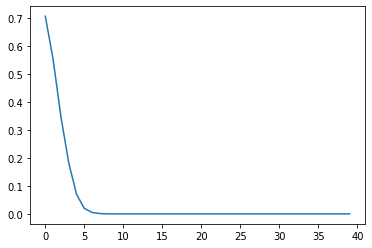

Test Accuracy of the model on the 1874 test images: 0.85
ACCURACY:0.8513513513513513+/-0.0


In [66]:

acc = []
for it in range(num_times):
    mask = mask_train[:2*N0]
    trainset1 = torch.utils.data.Subset(train_data, mask)
    loaders = {
        'train' : torch.utils.data.DataLoader(trainset1, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),

        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),
    }
    num_epochs = 40
    set_seed()
    cnn = CNN()
    loss_func = nn.BCEWithLogitsLoss()
    
    optimizer = optim.SGD(cnn.parameters(), lr = 0.05,momentum=0.9)   
    
    losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
    plt.figure(it)
    plt.plot(losses)
    plt.show()
    acc.append(test(cnn,loaders))
print(f'ACCURACY:{np.mean(acc)}+/-{np.std(acc)}')

# Running 20 epochs with N0 samples

In [26]:
acc = []
for it in range(num_times):


    mask = mask_train[:N0]

    trainset1 = torch.utils.data.Subset(train_data, mask)

    loaders = {
        'train' : torch.utils.data.DataLoader(trainset1, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),

        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),
    }
    set_seed()
    cnn = CNN()
    loss_func = nn.BCEWithLogitsLoss() 
    optimizer = optim.SGD(cnn.parameters(), lr = 0.05,momentum=0.9)   

    
    
    num_epochs = 20
    losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
    plt.figure(it)
    plt.plot(losses)
    plt.show()
    acc.append(test(cnn,loaders))

    torch.save({
            'model_state_dict': cnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'MNIST_model_iter_{it}.pt')



        
print(f'ACCURACY:{np.mean(acc)}+/-{np.std(acc)}')

Parameter containing:
tensor([[[[-0.0015,  0.1073, -0.1646, -0.1472, -0.0770],
          [ 0.0536, -0.0040,  0.1586, -0.0177,  0.0529],
          [-0.0604, -0.0393, -0.1911, -0.1325, -0.0824],
          [ 0.0074,  0.0791,  0.1200, -0.1356, -0.0871],
          [ 0.0726,  0.1661, -0.0412,  0.1497, -0.0322]]],


        [[[ 0.0212,  0.1811, -0.1855, -0.1259, -0.0506],
          [-0.0780,  0.1728, -0.1296, -0.0921, -0.1397],
          [-0.1873, -0.1167,  0.1719,  0.0892,  0.0969],
          [ 0.0105, -0.1025,  0.0338, -0.1867, -0.1445],
          [-0.1031,  0.1262,  0.1173, -0.0887, -0.0072]]],


        [[[ 0.1279,  0.1988,  0.0794,  0.0270,  0.1341],
          [-0.1178,  0.0373, -0.1551, -0.1386, -0.1033],
          [ 0.0905,  0.0804, -0.1185,  0.0604,  0.1098],
          [-0.0252,  0.0076,  0.0463,  0.1241,  0.1920],
          [-0.1541, -0.0733,  0.0786,  0.1657,  0.1740]]],


        [[[ 0.1765,  0.0398, -0.1739,  0.0184, -0.1251],
          [-0.1864,  0.1777,  0.1521, -0.1995,  0.0374

ssssssssssssssssssssssss
Parameter containing:
tensor([[[[-0.0015,  0.1073, -0.1646, -0.1472, -0.0770],
          [ 0.0536, -0.0040,  0.1586, -0.0177,  0.0529],
          [-0.0604, -0.0393, -0.1911, -0.1325, -0.0824],
          [ 0.0074,  0.0791,  0.1200, -0.1356, -0.0871],
          [ 0.0726,  0.1661, -0.0412,  0.1497, -0.0322]]],


        [[[ 0.0212,  0.1811, -0.1855, -0.1259, -0.0506],
          [-0.0780,  0.1728, -0.1296, -0.0921, -0.1397],
          [-0.1873, -0.1167,  0.1719,  0.0892,  0.0969],
          [ 0.0105, -0.1025,  0.0338, -0.1867, -0.1445],
          [-0.1031,  0.1262,  0.1173, -0.0887, -0.0072]]],


        [[[ 0.1279,  0.1988,  0.0794,  0.0270,  0.1341],
          [-0.1178,  0.0373, -0.1551, -0.1386, -0.1033],
          [ 0.0905,  0.0804, -0.1185,  0.0604,  0.1098],
          [-0.0252,  0.0076,  0.0463,  0.1241,  0.1920],
          [-0.1541, -0.0733,  0.0786,  0.1657,  0.1740]]],


        [[[ 0.1765,  0.0398, -0.1739,  0.0184, -0.1251],
          [-0.1864,  0.1777, 

ssssssssssssssssssssssss
Parameter containing:
tensor([[[[-0.0016,  0.1072, -0.1645, -0.1471, -0.0771],
          [ 0.0535, -0.0041,  0.1585, -0.0178,  0.0528],
          [-0.0605, -0.0394, -0.1912, -0.1326, -0.0825],
          [ 0.0073,  0.0790,  0.1199, -0.1357, -0.0872],
          [ 0.0725,  0.1660, -0.0413,  0.1496, -0.0323]]],


        [[[ 0.0213,  0.1812, -0.1854, -0.1258, -0.0505],
          [-0.0779,  0.1729, -0.1295, -0.0920, -0.1396],
          [-0.1872, -0.1166,  0.1720,  0.0893,  0.0970],
          [ 0.0106, -0.1024,  0.0337, -0.1866, -0.1444],
          [-0.1032,  0.1263,  0.1172, -0.0886, -0.0071]]],


        [[[ 0.1278,  0.1987,  0.0793,  0.0269,  0.1340],
          [-0.1179,  0.0372, -0.1552, -0.1387, -0.1032],
          [ 0.0904,  0.0803, -0.1186,  0.0603,  0.1097],
          [-0.0253,  0.0075,  0.0462,  0.1240,  0.1919],
          [-0.1542, -0.0734,  0.0785,  0.1656,  0.1741]]],


        [[[ 0.1764,  0.0397, -0.1740,  0.0185, -0.1252],
          [-0.1863,  0.1776, 

ssssssssssssssssssssssss
Parameter containing:
tensor([[[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        

ssssssssssssssssssssssss
Parameter containing:
tensor([[[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        

ssssssssssssssssssssssss
Parameter containing:
tensor([[[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        

ssssssssssssssssssssssss
Parameter containing:
tensor([[[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]],


        

KeyboardInterrupt: 

## adding N0 more samples using randomization

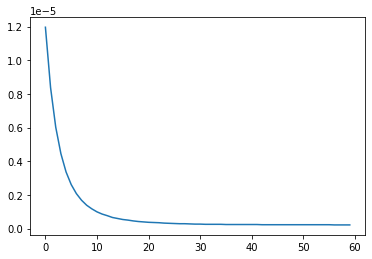

Test Accuracy of the model on the 1874 test images: 0.88
ACCURACY:0.8783783783783784+/-0.0


In [44]:
acc = []
for it in range(num_times):
 
    ############starting next set of iterations#########################
    
    loss_func = nn.BCEWithLogitsLoss()
    set_seed()
    cnn = CNN()
    optimizer = optim.SGD(cnn.parameters(), lr = 0.05, momentum=0.9)
    cnn.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['model_state_dict'])
    optimizer.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['optimizer_state_dict'])
    
    
    mask = mask_train[:2*N0]#list(range(N0,2*N0))
    trainset2 = torch.utils.data.Subset(train_data, mask)


    loaders = {
        'train' : torch.utils.data.DataLoader(trainset2, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),
        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),
    }
    num_epochs = 60
    losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
    plt.figure(it+num_times)
    plt.plot(losses)
    plt.show()
    acc.append(test(cnn,loaders))
print(f'ACCURACY:{np.mean(acc)}+/-{np.std(acc)}')

# Running 20 epochs with N0 samples and add N0 more samples using active learning for next 20 epochs

In [8]:
def AL_samples(trainset1,cnn,add_num):
    with torch.no_grad():
        correct = 0
        total = 0
        pred = []
        cnt = 0
        for images, labels in torch.utils.data.DataLoader(trainset1, batch_size=100, shuffle=False, num_workers=1):
            train_output, last_layer = cnn(images)
            pred_y = torch.nn.functional.sigmoid(train_output.squeeze())
            #print(pred_y)
            #pred.append(pred_y)
            if cnt == 0:
                pred = pred_y
            else:
                pred = torch.cat( (pred, pred_y), 0 )
            cnt += 1
        
        ind = np.argsort(abs(pred - 0.5))
        return ind[:add_num]

/home/m256149/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


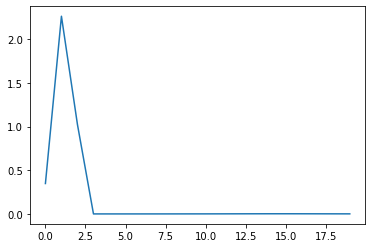

Test Accuracy of the model on the 1874 test images: 0.99
ACCURACY:0.9864864864864865+/-0.0


In [46]:
acc = []
for it in range(num_times):

    ############starting next set of iterations#########################
    
    loss_func = nn.BCEWithLogitsLoss() 
    set_seed()
    cnn = CNN()
    optimizer = optim.SGD(cnn.parameters(), lr = 0.05, momentum=0.9)
    cnn.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['model_state_dict'])
    optimizer.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['optimizer_state_dict'])
    

    
    mask = mask_train[N0:]
    trainset1 = torch.utils.data.Subset(train_data, mask)
    new_mask = torch.cat((mask[AL_samples(trainset1,cnn,N0)],mask_train[:N0]))
    trainset2 = torch.utils.data.Subset(train_data, new_mask)

    loaders = {
        'train' : torch.utils.data.DataLoader(trainset2, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),
        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),
    }
    num_epochs = 20
    losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
    plt.figure(it+num_times)
    plt.plot(losses)
    plt.show()
    acc.append(test(cnn,loaders))
print(f'ACCURACY:{np.mean(acc)}+/-{np.std(acc)}')

## Running 20 epochs with N0 samples and add N0 more samples using active learning for next 20 epochs and train only last layer

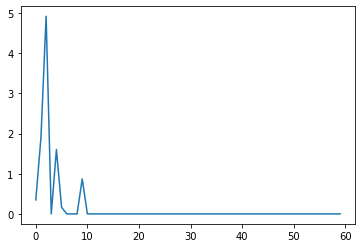

Test Accuracy of the model on the 1874 test images: 0.96
ACCURACY:0.9594594594594594+/-0.0


In [13]:
acc = []
for it in range(num_times):

    ############starting next set of iterations#########################
    
    loss_func = nn.BCEWithLogitsLoss()
    set_seed()
    cnn = CNN()
    optimizer = optim.SGD(cnn.parameters(), lr = 0.05, momentum = 0.9)
    cnn.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['model_state_dict'])
    optimizer.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['optimizer_state_dict'])
    for cnt, param in enumerate(cnn.parameters()):
        if cnt < 4:
            param.requires_grad = False
    
    
    mask = mask_train[N0:]
    trainset1 = torch.utils.data.Subset(train_data, mask)
    new_mask = torch.cat((mask[AL_samples(trainset1,cnn,N0)],mask_train[:N0]))
    trainset2 = torch.utils.data.Subset(train_data, new_mask)

    loaders = {
        'train' : torch.utils.data.DataLoader(trainset2, 
                                              batch_size=100, 
                                              shuffle=True, 
                                              num_workers=1),
        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=100, 
                                              shuffle=True, 
                                              num_workers=1),
    }
    num_epochs = 60
    losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
    plt.figure(it+num_times)
    plt.plot(losses)
    plt.show()
    acc.append(test(cnn,loaders))
print(f'ACCURACY:{np.mean(acc)}+/-{np.std(acc)}')

## adding N0 more samples using expected gradient length

In [48]:
def AL_grad_samples(trainset1,cnn,add_num,nr):
    cnn.train()
    score_train = []
    for images, labels in torch.utils.data.DataLoader(trainset1, batch_size=1, shuffle=False, num_workers=1):

        cnn.zero_grad()
        train_output, last_layer = cnn(images)
        train_output.backward()
        pred_y = torch.nn.functional.sigmoid(train_output.squeeze()).item()
        s = 0
        for param in cnn.parameters():
            if nr == 'fro':
                s += torch.norm(param.grad).item()
            elif nr == 'l0':
                s += torch.count_nonzero(param.grad>1e-8).item()
            elif nr == 'l1':
                s += torch.norm(param.grad,p = 1).item()
        score_train.append( 2*s*pred_y*(1-pred_y) )
    ind = np.argsort(score_train)
    return ind[-add_num:]

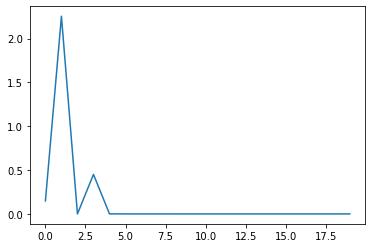

Test Accuracy of the model on the 1874 test images: 0.96
ACCURACY:0.9594594594594594+/-0.0


In [51]:
acc = []
for it in range(num_times):

    ############starting next set of iterations#########################

    loss_func = nn.BCEWithLogitsLoss() 
    set_seed()
    cnn = CNN()
    optimizer = optim.SGD(cnn.parameters(), lr = 0.05, momentum = 0.9)
    cnn.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['model_state_dict'])

    mask = mask_train[N0:]
    trainset1 = torch.utils.data.Subset(train_data, mask)
    new_mask = torch.cat((mask[AL_grad_samples(trainset1,cnn,1,'fro')],mask_train[:N0]))
    trainset2 = torch.utils.data.Subset(train_data, new_mask)

    cnn.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['model_state_dict'])
    optimizer.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['optimizer_state_dict'])
    

    loaders = {
        'train' : torch.utils.data.DataLoader(trainset2, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),
        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=100, 
                                              shuffle=False, 
                                              num_workers=1),
    }
    num_epochs = 20
    losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
    plt.figure(it+num_times)
    plt.plot(losses)
    plt.show()
    acc.append(test(cnn,loaders))
print(f'ACCURACY:{np.mean(acc)}+/-{np.std(acc)}')

## adding N0 samples one at a time using active learning expected gradient length

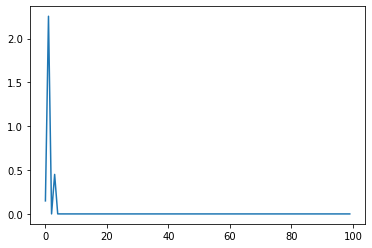

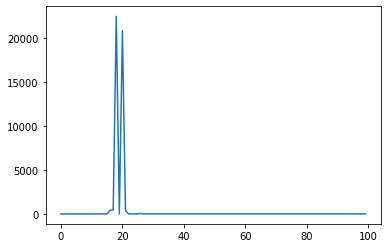

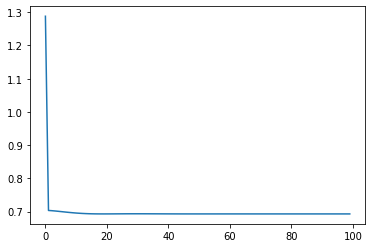

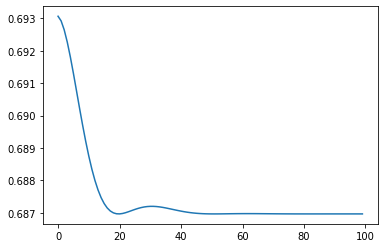

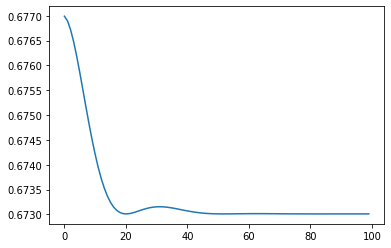

Test Accuracy of the model on the 1874 test images: 0.43
ACCURACY:0.43243243243243246+/-0.0


In [68]:
acc = []
for it in range(num_times):

    ############starting next set of iterations#########################

    loss_func = nn.BCEWithLogitsLoss() 
    set_seed()
    cnn = CNN()
    optimizer = optim.SGD(cnn.parameters(), lr = 0.05, momentum = 0.9)
    cnn.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['model_state_dict'])

    mask = mask_train[N0:]
    trainset1 = torch.utils.data.Subset(train_data, mask)
    new_mask = torch.cat((mask[AL_grad_samples(trainset1,cnn,1,'fro')],mask_train[:N0]))
    trainset2 = torch.utils.data.Subset(train_data, new_mask)

    cnn.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['model_state_dict'])
    optimizer.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['optimizer_state_dict'])
    

    loaders = {
        'train' : torch.utils.data.DataLoader(trainset2, 
                                              batch_size=100, 
                                              shuffle=True, 
                                              num_workers=1),
        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=100, 
                                              shuffle=True, 
                                              num_workers=1),
    }
    num_epochs = 100
    losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
    plt.figure(it+num_times)
    plt.plot(losses)
    plt.show()

        
    for n in range(1,N0):       
        #mask = mask_train - new_mask
        mask = [i for i in mask_train if i not in new_mask]
        trainset1 = torch.utils.data.Subset(train_data, mask)
        new_mask = torch.cat((torch.tensor([mask[torch.tensor(AL_grad_samples(trainset1,cnn,1,'l1'))]]),new_mask))
        trainset2 = torch.utils.data.Subset(train_data, new_mask)


        loaders = {
            'train' : torch.utils.data.DataLoader(trainset2, 
                                                  batch_size=100, 
                                                  shuffle=True, 
                                                  num_workers=1),
            'test'  : torch.utils.data.DataLoader(test_data, 
                                                  batch_size=100, 
                                                  shuffle=True, 
                                                  num_workers=1),
        }
        #num_epochs = 100
        losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
        plt.figure(it+num_times+n)
        plt.plot(losses)
        plt.show()


    acc.append(test(cnn,loaders))
print(f'ACCURACY:{np.mean(acc)}+/-{np.std(acc)}')

## adding samples one at a time using just close to margin criteria

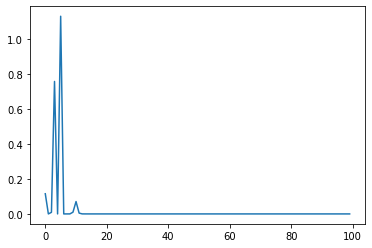

<ipython-input-69-9644853998b3>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_mask = torch.cat((torch.tensor([mask[torch.tensor(AL_samples(trainset1,cnn,1))]]),new_mask))


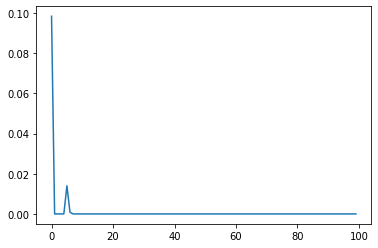

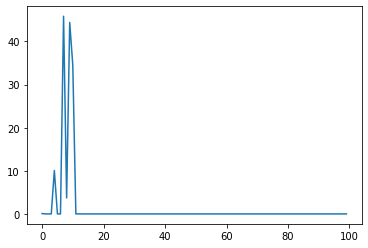

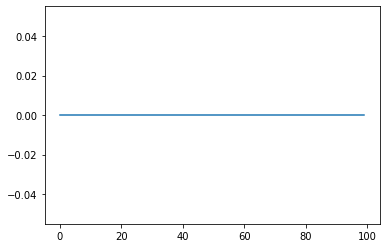

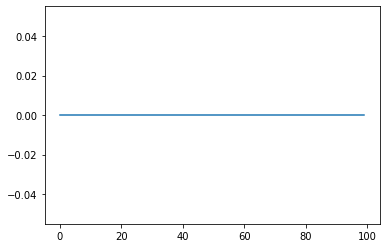

Test Accuracy of the model on the 1874 test images: 0.84
ACCURACY:0.8378378378378378+/-0.0


In [69]:
acc = []
for it in range(num_times):

    ############starting next set of iterations#########################

    loss_func = nn.BCEWithLogitsLoss() 
    set_seed()
    cnn = CNN()
    optimizer = optim.SGD(cnn.parameters(), lr = 0.05, momentum = 0.9)
    cnn.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['model_state_dict'])

    mask = mask_train[N0:]
    trainset1 = torch.utils.data.Subset(train_data, mask)
    new_mask = torch.cat((mask[AL_samples(trainset1,cnn,1)],mask_train[:N0]))
    trainset2 = torch.utils.data.Subset(train_data, new_mask)

    cnn.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['model_state_dict'])
    optimizer.load_state_dict(torch.load(f'MNIST_model_iter_{it}.pt')['optimizer_state_dict'])
    

    loaders = {
        'train' : torch.utils.data.DataLoader(trainset2, 
                                              batch_size=100, 
                                              shuffle=True, 
                                              num_workers=1),
        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=100, 
                                              shuffle=True, 
                                              num_workers=1),
    }
    num_epochs = 100
    losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
    plt.figure(it+num_times)
    plt.plot(losses)
    plt.show()

        
    for n in range(1,N0):       
        #mask = mask_train - new_mask
        mask = [i for i in mask_train if i not in new_mask]
        trainset1 = torch.utils.data.Subset(train_data, mask)
        new_mask = torch.cat((torch.tensor([mask[torch.tensor(AL_samples(trainset1,cnn,1))]]),new_mask))
        trainset2 = torch.utils.data.Subset(train_data, new_mask)


        loaders = {
            'train' : torch.utils.data.DataLoader(trainset2, 
                                                  batch_size=100, 
                                                  shuffle=True, 
                                                  num_workers=1),
            'test'  : torch.utils.data.DataLoader(test_data, 
                                                  batch_size=100, 
                                                  shuffle=True, 
                                                  num_workers=1),
        }
        #num_epochs = 20
        losses = train(num_epochs, cnn, loaders, optimizer, loss_func)
        plt.figure(it+num_times+n)
        plt.plot(losses)
        plt.show()


    acc.append(test(cnn,loaders))
print(f'ACCURACY:{np.mean(acc)}+/-{np.std(acc)}')